<a href="https://colab.research.google.com/github/luida-M/Modelo_ML/blob/main/Proyecto_ParteIII%2BMedina_Tenorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este proyecto tiene como dataset los tipos de ventas de los supermercados a nivel nacional del país de Argentina. Se realiza un análisis de datos para predecir **'ventas_precios_corrientes'** utilizando diferentes algoritmos de regresión.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Modelo_ML
git@github.com: Permission denied (publickey).
# github.com:22 SSH-2.0-159e461a3
# github.com:22 SSH-2.0-159e461a3
# github.com:22 SSH-2.0-159e461a3
# github.com:22 SSH-2.0-159e461a3
# github.com:22 SSH-2.0-159e461a3
/root/.ssh/id_ed25519 already exists.
Overwrite (y/n)? y
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIBC6kA4+yEaFeTm0UredpLyvrGwHJixRZnHagN2On0jS luidamedina@gmail.com
fatal: destination path 'Modelo_ML' already exists and is not an empty directory.
/content/drive/MyDrive/Colab Notebooks/Modelo_ML
   indice_tiempo  ventas_precios_corrientes  ventas_precios_constantes  \
0            NaN                27858.87208                27477.30767   
1            NaN                25994.20017                25223.42886   
2            NaN                27780.00652                26334.26364   
3            NaN 

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['indice_tiempo']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


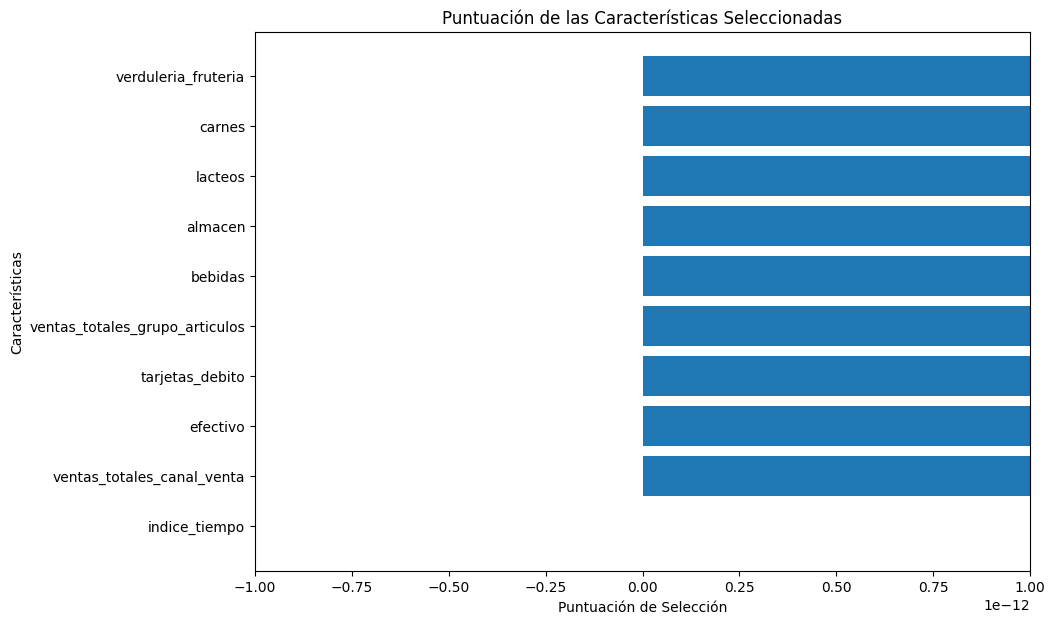

Tamaño del subconjunto de entrenamiento: 82
Tamaño del subconjunto de prueba: 10
Linear Regression - Mean Squared Error: 6.125390604614106e-21
Linear Regression - R^2 Score: 1.0
Random Forest - Mean Squared Error: 108423700.4066025
Random Forest - R^2 Score: 0.999036282635536
Ridge Regression - Mean Squared Error: 3.0744876867364175e-10
Ridge Regression - R^2 Score: 1.0
Lasso Regression - Mean Squared Error: 2.451283046183048e-16
Lasso Regression - R^2 Score: 1.0
ElasticNet Regression - Mean Squared Error: 2.6395154722822267e-16
ElasticNet Regression - R^2 Score: 1.0


<ipython-input-2-79c74052de7e>:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.05, 1, 0.05])


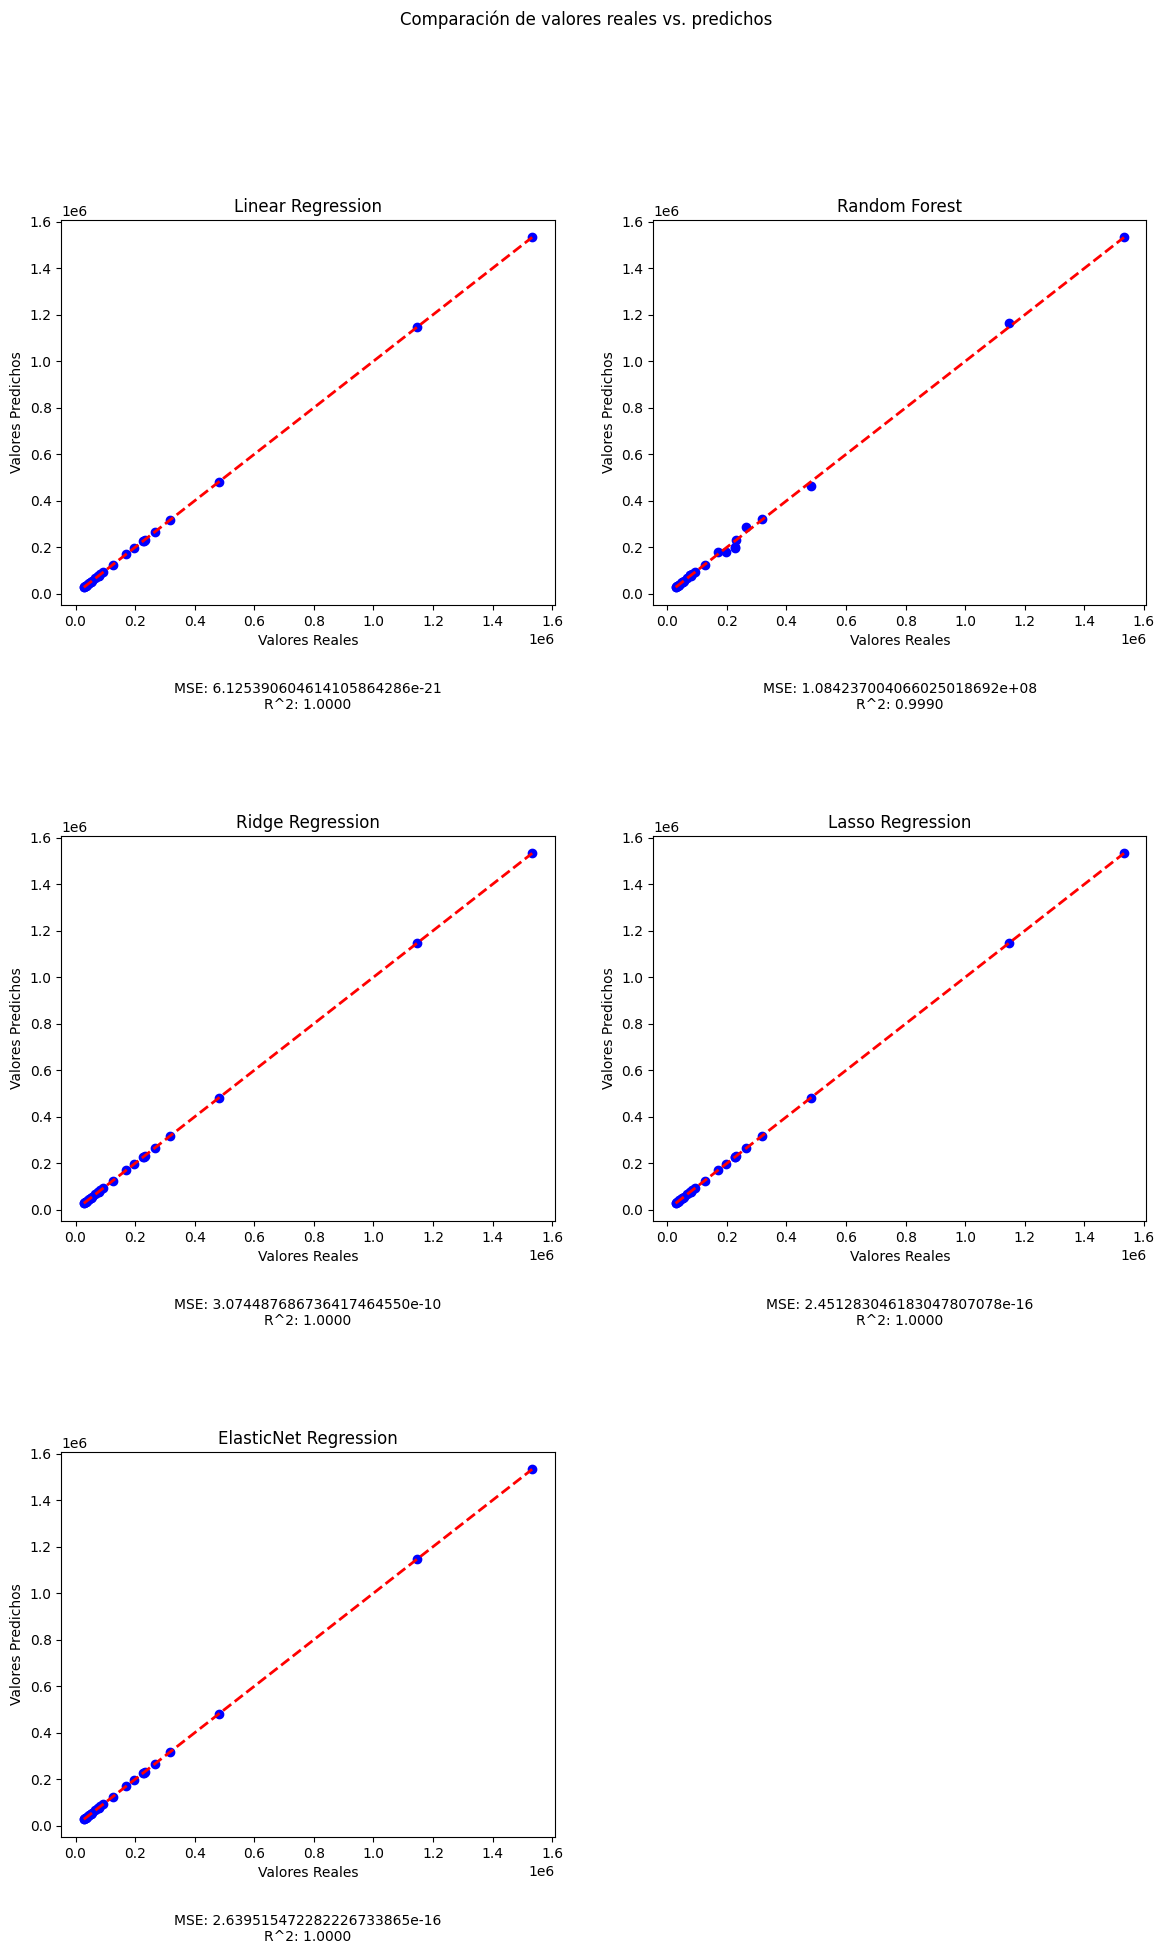

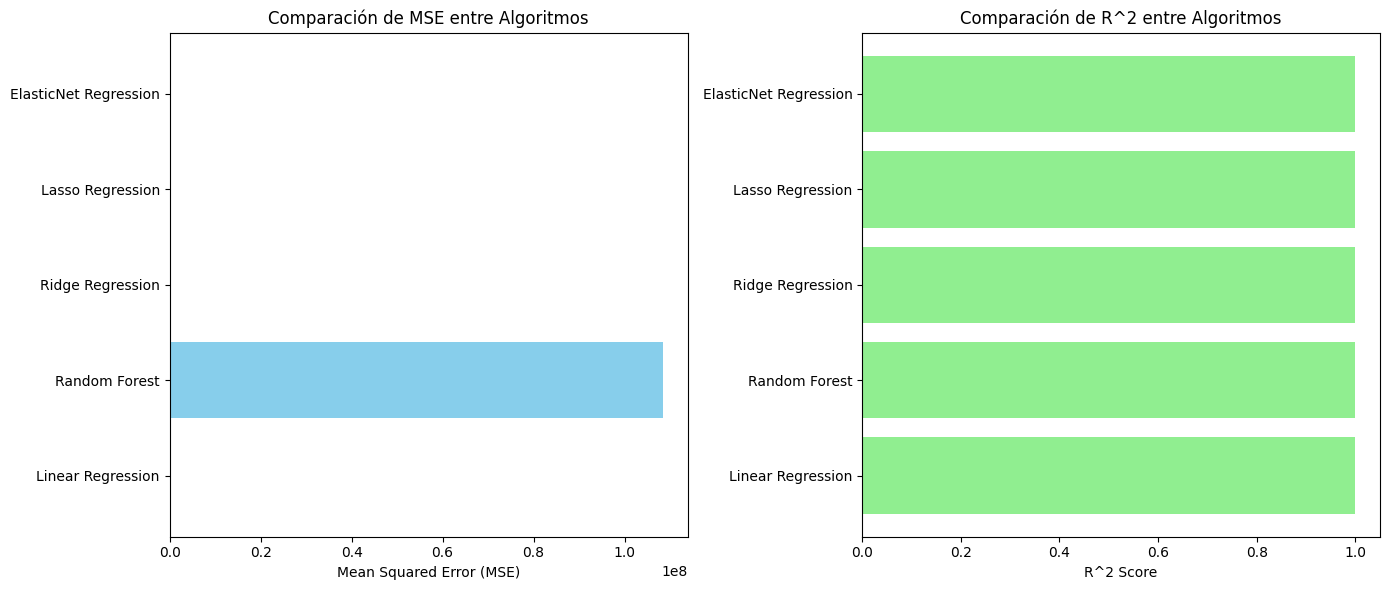


    1. Las características seleccionadas para el modelo son: indice_tiempo, ventas_totales_canal_venta, efectivo, tarjetas_debito, ventas_totales_grupo_articulos, bebidas, almacen, lacteos, carnes, verduleria_fruteria.
    2. El mejor algoritmo de regresión fue Linear Regression, con un error cuadrático medio (MSE) de 6.125390604614106e-21 y un R^2 Score de 1.0.
    3. Las características seleccionadas han mostrado ser relevantes para predecir 'ventas_precios_corrientes'.
    4. Se recomienda utilizar el algoritmo Linear Regression para predicciones futuras, ya que presentó el mejor desempeño en términos de MSE y R^2 Score.
    
From https://github.com/luida-M/Modelo_ML
 * branch            main       -> FETCH_HEAD
Already up to date.
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


In [2]:
#  Montaje de Google Drive para acceder a los archivos necesarios.
from google.colab import drive
import os
drive.mount('/content/drive')

# Establecer ruta de acceso en drive
print(os.getcwd())
os.chdir("/content/drive/MyDrive/Colab Notebooks")

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
import gspread
from google.auth import default
from google.colab import auth
from sklearn.impute import SimpleImputer

# Autenticación con Google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

!ssh -T git@github.com

# Configuración de Git
!git config --global user.email "luidamedina@gmail.com"
!git config --global user.name "Luida Medina"

# Configurar SSH
!mkdir -p /root/.ssh
!ssh-keyscan github.com >> ~/.ssh/known_hosts

# Generar una nueva clave SSH
!ssh-keygen -t ed25519 -C "luidamedina@gmail.com" -f /root/.ssh/id_ed25519 -q -N ""

# Mostrar la clave pública para copiarla y agregarla a GitHub
!cat /root/.ssh/id_ed25519.pub

# Clona el repositorio usando SSH
!git clone git@github.com:luida-M/Modelo_ML.git
%cd Modelo_ML

# Carga de Datos desde Google Sheets
file_name = 'ventas-totales-supermercados-2'

try:
    sheet = gc.open(file_name).sheet1
    data = sheet.get_all_values()
    df = pd.DataFrame(data[1:], columns=data[0])
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.fillna(df.mean(), inplace=True)
except gspread.SpreadsheetNotFound:
    print(f"No se encontró el archivo '{file_name}' en Google Sheets. Asegúrate de que el nombre sea correcto.")
except Exception as e:
    print(f"Error al leer el archivo de Google Sheets: {e}")

if 'df' in locals():
    print(df.head())

    # Método de Feature Selection: SelectKBest
    features = ['indice_tiempo','ventas_precios_corrientes', 'ventas_precios_constantes', 'ventas_totales_canal_venta',
                'salon_ventas', 'canales_on_line', 'ventas_totales_medio_pago', 'efectivo', 'tarjetas_debito',
                'tarjetas_credito', 'otros_medios', 'ventas_totales_grupo_articulos', 'subtotal_ventas_alimentos_bebidas',
                'bebidas', 'almacen', 'panaderia', 'lacteos', 'carnes', 'verduleria_fruteria',
                'alimentos_preparados_rotiseria', 'articulos_limpieza_perfumeria', 'indumentaria_calzado_textiles_hogar',
                'electronicos_articulos_hogar', 'otros']

    X = df[features]
    y = df['ventas_precios_corrientes']

    # Manejar valores faltantes con SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    selector = SelectKBest(score_func=f_regression, k=10)
    X_new = selector.fit_transform(X, y)
    selected_features = [features[i] for i in selector.get_support(indices=True)]
    print(f"Selected Features: {', '.join(selected_features)}")

    # Visualización de las características seleccionadas
    plt.figure(figsize=(14, 7))
    plt.barh(selected_features, selector.scores_[selector.get_support()])
    plt.xlabel('Puntuación de Selección')
    plt.ylabel('Características')
    plt.title('Puntuación de las Características Seleccionadas')
    plt.show()

    # Preparar subconjuntos de datos para pruebas
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_new, y, test_size=0.1, random_state=42) # 10% test
    print("Tamaño del subconjunto de entrenamiento:", len(X_train_subset))
    print("Tamaño del subconjunto de prueba:", len(X_test_subset))

    #  Dividir Datos en Entrenamiento y Prueba
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42) # 70% train, 30% test

    # Algoritmos de Regresión
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Ridge Regression": Ridge(),
        "Lasso Regression": Lasso(),
        "ElasticNet Regression": ElasticNet()
    }

    # Entrenamiento y Evaluación
    results = {}
    num_models = len(models)
    num_cols = 2
    num_rows = (num_models + num_cols - 1) // num_cols  # Calcula el número de filas necesarias

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 7*num_rows))  # Ajuste del tamaño de la figura
    fig.suptitle('Comparación de valores reales vs. predichos')

    # Aplanar el array de axs si es necesario
    axs = axs.flatten() if num_rows > 1 else [axs]

    for idx, (name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {"MSE": mse, "R2": r2}
        print(f"{name} - Mean Squared Error: {mse}")
        print(f"{name} - R^2 Score: {r2}")

        # Crear gráficos en subgráficos
        axs[idx].scatter(y_test, y_pred, color='blue')
        axs[idx].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
        axs[idx].set_title(f'{name}')
        axs[idx].set_xlabel('Valores Reales')
        axs[idx].set_ylabel('Valores Predichos')

        # Mover el título del gráfico un poco más hacia arriba
        axs[idx].title.set_position([0.5, 0.2])

        # Mostrar los resultados debajo de cada gráfico
        axs[idx].text(0.5, -0.2, f'MSE: {mse:.21e}\nR^2: {r2:.4f}', ha='center', va='top', transform=axs[idx].transAxes, fontsize=10)

    # Oculta los gráficos vacíos en la última fila
    for i in range(num_models, num_rows * num_cols):
        fig.delaxes(axs[i])

    # Ajustar el espaciado para que los gráficos no se solapen
    plt.tight_layout(rect=[0, 0.05, 1, 0.05])
    plt.subplots_adjust(hspace=0.6)  # Ajustar el espacio vertical entre los subgráficos
    plt.show()

    # Visualización de Resultados
    mse_values = [results[name]["MSE"] for name in results]
    r2_values = [results[name]["R2"] for name in results]

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.barh(list(results.keys()), mse_values, color='skyblue')
    plt.xlabel('Mean Squared Error (MSE)')
    plt.title('Comparación de MSE entre Algoritmos')

    plt.subplot(1, 2, 2)
    plt.barh(list(results.keys()), r2_values, color='lightgreen')
    plt.xlabel('R^2 Score')
    plt.title('Comparación de R^2 entre Algoritmos')

    plt.tight_layout()
    plt.show()

    # Generación de Conclusiones
    mejores_resultados = sorted(results.items(), key=lambda x: x[1]["MSE"])[0]
    mejor_algoritmo = mejores_resultados[0]
    mejor_mse = mejores_resultados[1]["MSE"]
    mejor_r2 = mejores_resultados[1]["R2"]

    conclusiones = f"""
    1. Las características seleccionadas para el modelo son: {', '.join(selected_features)}.
    2. El mejor algoritmo de regresión fue {mejor_algoritmo}, con un error cuadrático medio (MSE) de {mejor_mse} y un R^2 Score de {mejor_r2}.
    3. Las características seleccionadas han mostrado ser relevantes para predecir 'ventas_precios_corrientes'.
    4. Se recomienda utilizar el algoritmo {mejor_algoritmo} para predicciones futuras, ya que presentó el mejor desempeño en términos de MSE y R^2 Score.
    """
    print(conclusiones)

    # Sincronizar con el repositorio remoto
    !git pull origin main

    # Subir cambios a GitHub
    !git add .
    !git commit -m "Análisis de datos y comparación de varios algoritmos de regresión"
    !git push origin main

else:
    print("No se puede proceder con el análisis ya que el archivo no se cargó correctamente.")